## The mean of the double-kink nucleation energy barrier distribution for dislocation of length $L = N\times l_{dk}$, where $l_{dk}\sim 10-20b$ is the double-kink nucleation length

$$\Delta\bar{H}^{sol}(c, N, \tau)=\sigma_{\Delta H^{sol}}(c, \tau)(b_{N}-\gamma a_{N}) $$

Here, $\gamma\approx 0.5772$, $a_{N}=\frac{1}{\sqrt{2\log(N)}}$, $b_{N}=\frac{\log(\log(N))+\log(4\pi)}{\sqrt{8\log(N)}}-\sqrt{2\log(N)}$ 

$$\sigma_{\Delta H^{sol}}(c, \tau) = \Delta\tilde{E}_{p}(a)G(\tau)$$

where

$$G(\tau)=\left(\sum_{k=-N_{s}}^{N_{s}}g(kb, \tau)^{2}\right)^{\frac{1}{2}}$$

is a geometrical shape factor and $N_{s}=l_{dk}/(2b)$ is the total number of atomic sites along the dislocation line z within one kink length $l_{dk}/2$.

## Double-kink transition configurations

$x_{disl}(z, \tau)$: dislocation shape of the double-kink transition state versus applied stress, $\tau$

$$x_{disl}(z, \tau)/a = g(z,\tau)+g_{eq}(\tau)$$
 The configurations are usually fitted to a function form for $g(z,\tau)$ as 

$$g(z, \tau)=\frac{1}{2}\left(\tanh\left[\frac{z/b+\zeta(\tau)}{\alpha(\tau)}\right]-\tanh\left[\frac{z/b-\zeta(\tau)}{\alpha(\tau)}\right]\right)$$

where $\alpha$, $\zeta$ are fitting  parameters and $g_{eq}(\tau)$ is the initial straight screw dislocation position at stress $\tau$.

## The total rate of double-kink nucleation 

$$R =\nu_0 N \exp\left(-\frac{\Delta H_{dk}}{kT}\right)$$

where
$$\Delta H_{dk} = \Delta H^{0}(\tau) -\left(\sqrt{2}\sigma_{\Delta H^{sol}}(c, \tau)+kT\log\left(\frac{1}{2}\mathrm{erfc}\left[\right]\right)\right)$$

# Migration controlled strength
$$\tau(\dot{\epsilon},T)=\tau_c\left[3.26*\left(\frac{\Delta H^{exp}}{\Delta \tilde{E}_p}-0.035\sqrt{L/b}+1.07\sqrt{w/b}\right)^{-1}-2.7\sqrt{b/L}\right]$$


$$\Delta H_{km}=\Delta \tilde{E}_p\left[3.26\left(\frac{\tau}{\tau_c}+\frac{2.7}{\sqrt{L/b}}\right)^{-1}+0.035\sqrt{L/b}-1.07\sqrt{w/b}\right]$$

where

$$\tau_c = \frac{\Delta \tilde{E}_p}{ab^2}$$

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
import pandas as pd
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline


### Functions Definition

In [112]:
k = 8.617333*1e-2 # Boltzmann constant
gamma = 0.5772

def DEp(c, DEp0):
    return DEp0*np.sqrt(c)

def G(tau):
    return polynomial_G(tau)

def sigma_DH(c, tau, DEp0):
    return DEp(c, DEp0) * G(tau)

def DH_sol(c, N, tau):
    return sigma_DH(c, tau, DEp0) * (b(N) - gamma * a(N))

def DH_0(tau, tau_p):
    return polynomial_barrier_Fe(tau*tau_p)

def aa(N):
    return 1/(np.sqrt(2*np.log(N)))

def bb(N):
    return (np.log(np.log(N))+np.log(4*np.pi))/(np.sqrt(8*np.log(N)))-np.sqrt(2*np.log(N))

def DH_dk(c, N, DEp0, tau, tau_p, T):

    x = -(bb(N) - gamma * aa(N))/(np.sqrt(2)) + sigma_DH(c, tau, DEp0)/(np.sqrt(2)*k*T)
    DH = DH_0(tau, tau_p)-2*(sigma_DH(c, tau, DEp0)/(np.sqrt(2))) + k*T*np.log(0.5*math.erf(x))
    return DH

def DH_km(c, L, b, DEp0, tau, w):
    
    a=0.943*b
    tau_c = DEp(c, DEp0)/(a*b**2)
    DH = DEp(c, DEp0)*((3.26*(tau/160.218/tau_c*np.sqrt(L/2)+1.91)**(-1)+0.05)*np.sqrt(L/2)-1.07*np.sqrt(w))
    return DH

#def DH_km(c, L, b, DEp0, tau, w):
    
#    a=0.943*b
#    DH = (DEp(c, DEp0)*DEp(c, DEp0)/(a*b**2*tau/160.218))*(0.5*np.log((a*b**2*tau/160.218)**2*L/(DEp(c, DEp0)**2))+2*0.49088)-1.24*DEp(c, DEp0)*np.sqrt(1.5*w)
#    return DH


# barrier_type='dk' : the stress is computed based on the double-kink barrier
# barrier_type='km' : the stress is computed based on the kink migration barrier
# barrier_type='both' : the stress is computed based on the maximum of double-kink and kink migration barrier
def yield_stress_alloy(c, L, b, N, w, T, DEp0, tau_p, strain_rate, strain_rate_exp, if_plot):

    stress_list = np.linspace(0, 1, 21)
    # Double-kink nucleation barrier versus stress
    stress_DH_dk = np.array([[tau, DH_dk(c, N, DEp0, tau, tau_p, T)] for tau in stress_list])
    stress_list_km = np.linspace(10, 1000, 101)
    # Kink migration barrier versus stress
    stress_DH_km = np.array([[tau, DH_km(c, L, b, DEp0, tau, w)] for tau in stress_list_km])
    # Define the target value y0
    y0 = k*T*np.log(strain_rate/strain_rate_exp)
    # This is the y-value for which we want to solve f(x) = y0

    #coefficients_dk = np.polyfit(stress_DH_dk[:, 0], stress_DH_dk[:, 1], 10)
    # Generate a polynomial function from the coefficients
    #polynomial_f_dk = np.poly1d(coefficients_dk)
    polynomial_f_dk = UnivariateSpline(stress_DH_dk[:, 0], stress_DH_dk[:, 1], s=1)

    #coefficients_km = np.polyfit(stress_DH_km[:, 0], stress_DH_km[:, 1], 10)
    # Generate a polynomial function from the coefficients
    sp_f = UnivariateSpline(stress_DH_km[:, 0], stress_DH_km[:, 1], s=1)

    if if_plot:
        plt.plot(stress_DH_dk[:,0]*tau_p, DH_0(stress_DH_dk[:,0], tau_p), 'r-', label='pure metal')
        plt.plot(stress_DH_dk[:,0]*tau_p, stress_DH_dk[:,1], 'b-',label='alloy (dk)')   
        plt.plot(stress_DH_km[:,0], stress_DH_km[:,1], '-', color='purple', label='alloy (km)')
        plt.plot([0, 1000], [y0, y0], 'g--', label='imposed experimental barrier')
        plt.xlabel(r'$\tau/\tau_p$', fontsize=15)
        plt.ylabel(r'$\Delta H$ (meV)', fontsize=15)
        plt.ylim(0, )
        plt.legend(loc=0, fontsize=12)
        plt.show()


    # Define the function f(x) - y0
    def equation_to_solve_dk(x):
        return polynomial_f_dk(x) - y0

    def equation_to_solve_km(x):
        return sp_f(x) - y0

    # Solve the equation f(x) - y0 = 0 using root_scalar within a specific interval

    x_min_dk, x_max_dk = 0, 1
    x_min_km, x_max_km = 0, 1000

    # Define the interval where you expect the solution to be
    
    try:
        result_dk = root_scalar(equation_to_solve_dk, bracket=[x_min_dk, x_max_dk], method='brentq')
        tau_dk = result_dk.root * tau_p
    except:
        tau_dk = 0
    try:
        result_km = root_scalar(equation_to_solve_km, bracket=[x_min_km, x_max_km], method='brentq')
        tau_km = result_km.root
    except:
        tau_km = 0
    return max(tau_dk, tau_km)

# Application to Fe-Si alloys

### Step 1: Convert stress-temperature curve to barrier-stress 

__temp_stress_Fe_exp__ is the stress-temperature data that should be provided

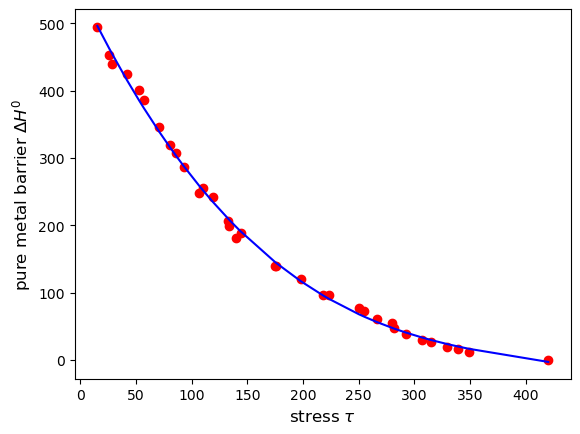

In [113]:
strain_rate_exp = 1.7*10**(-4) # experimental strain rate
strain_rate = 10**(4) # reference strain rate

# stress versus temperature values from experiments/simulations
temp_stress_Fe_exp = np.array([[7.5, 349], [10.5, 339], [12.5, 329], [17.5, 315], [19, 307], [25, 292], [30.5, 282], [35, 280], [39.5, 266], [47, 255], 
 [50, 250], [62, 223], [62.5, 218], [77.5, 198], [90.5, 176], [90, 175], [122, 144], [117.5, 140], [129, 134], [133.5, 133], 
 [157, 119], [165.5, 110], [160.5, 107], [186, 93], [199, 86], [207.5, 81], [224, 71], [250, 57], [260, 53], [276, 42], [285.5, 29], 
 [294, 26], [320.5, 15.5]])

stress_barrier_Fe_exp = np.array([[temp_stress_Fe_exp[i][1], k*temp_stress_Fe_exp[i][0]*np.log(strain_rate/strain_rate_exp)] for i in range(len(temp_stress_Fe_exp))])
stress_barrier_Fe_exp = np.concatenate((np.array([[420, 0]]), stress_barrier_Fe_exp))

x = stress_barrier_Fe_exp[:, 0]
y = stress_barrier_Fe_exp[:, 1]

# Sort x and y based on x
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

coefficients = np.polyfit(x_sorted, y_sorted, 3)

# Generate a polynomial function from the coefficients
polynomial_barrier_Fe = np.poly1d(coefficients)

#plt.plot(temp_stress_Fe_exp[:,0], stress_temp_Fe_exp[:,1], 'ro')

plt.plot(stress_barrier_Fe_exp[:,0], stress_barrier_Fe_exp[:,1], 'ro')
plt.plot(stress_barrier_Fe_exp[:,0], polynomial_barrier_Fe(stress_barrier_Fe_exp[:,0]), 'b-')
plt.xlabel(r'stress $\tau$', fontsize=12)
plt.ylabel(r'pure metal barrier $\Delta H^{0}$', fontsize=12)
plt.show()

### Step 2: Define Geometric function G (see the last cell of the NoteBook)

__stress_G_Fe_GAP_potential__ is the Geometric data that should be provided (a helper function is provided in the end to compute G)

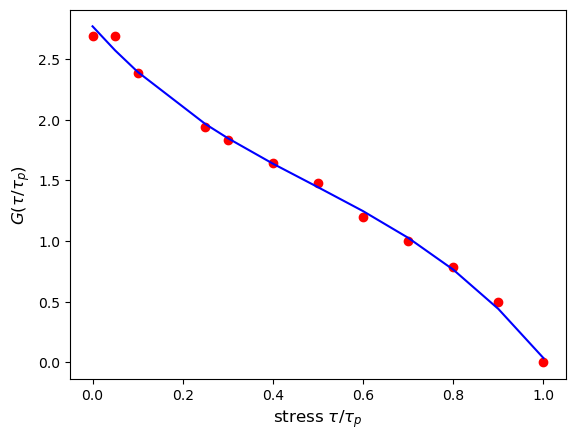

In [114]:
# G values are computed before for normalized stresses 
stress_G_Fe_GAP_potential = np.array([[0, 2.68931], [0.05, 2.68931], [0.1, 2.38921], [0.25, 1.94007], 
                                      [0.3, 1.83740], [0.4, 1.646560], [0.5, 1.4822], [0.6, 1.19729] , 
                                      [0.7, 1.0029], [0.8, 0.7852], [0.9, 0.4937], [1, 0]])
x = stress_G_Fe_GAP_potential[:, 0]
y = stress_G_Fe_GAP_potential[:, 1]

# Sort x and y based on x
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

coefficients = np.polyfit(x_sorted, y_sorted, 3)

# Generate a polynomial function from the coefficients
polynomial_G = np.poly1d(coefficients)

plt.plot(stress_G_Fe_GAP_potential[:,0], stress_G_Fe_GAP_potential[:,1], 'ro')
plt.plot(stress_G_Fe_GAP_potential[:,0], polynomial_G(stress_G_Fe_GAP_potential[:,0]), 'b-')
plt.xlabel(r'stress $\tau/\tau_p$', fontsize=12)
plt.ylabel(r'$G(\tau/\tau_p)$', fontsize=12)
plt.show()

# Step 3: Yield stress prediction based on double-kink and kink-migration mechanisms 

Alloy yield stress = max(sigma_dk, sigma_km)

## example 

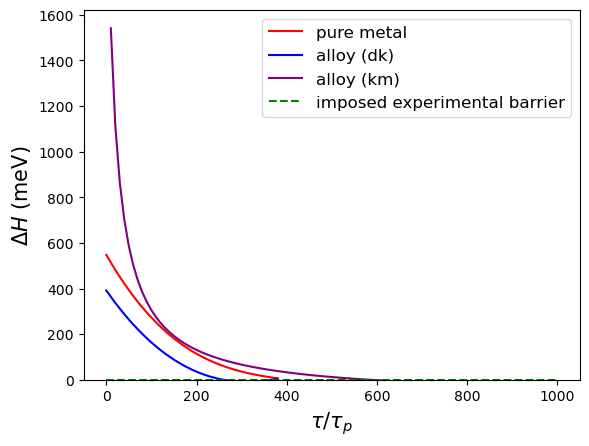

yield stress = 577.1652726932462


In [115]:
c = 0.05 # solute concentration
DEp0 = 178 # solute/screw interaction energy parameter (meV), independent from c
b=2.7
L = 10000/b # L=1 micrometer/b, total dislocation length.
L_mig = 0.75 * L # Length for kink migration, the average distance between l and l/2 (refer to the kink migration Acta. Mat. paper)
w=12 # kink-width
N = int(L/(2*w)) # number of double-kink nucleation sites in a dislocation of length L; L/l_dk
T = 1 # Temperature
tau_p = 380 # Peierls stress (MPa) for pure metal (from experiment or simulation)
strain_rate_exp = 1.7*10**(-4) # experimental strain rate
strain_rate = 10**(4) # reference strain rate

# Just to give you a taste
stress = yield_stress_alloy(c=c,
                         L=L_mig,
                         b = b,
                         N=N, 
                         w=w,
                         T = T,
                         DEp0=DEp0,         
                         tau_p=tau_p, 
                         strain_rate=strain_rate, 
                         strain_rate_exp=strain_rate_exp,
                         if_plot=True,
                        )

print(f'yield stress = {stress}')

# Stress versus temperature curve

In [116]:
c_range = [0.013, 0.05] # solute concentrations
T_range = np.linspace(10, 300, 100)
DEp0 = 178 # solute/screw interaction energy parameter (meV), independent from c
burger=2.7
L = 10000/burger # L=1 micrometer/b, total dislocation length.
L_mig = 0.75 * L # Length for kink migration, the average distance between l and l/2 (refer to the kink migration Acta. Mat. paper)
w=12 # kink-width
N = int(L/(2*w)) # number of double-kink nucleation sites in a dislocation of length L; L/l_dk
tau_p = 380 # Peierls stress (MPa) for pure metal (from experiment or simulation)
strain_rate_exp = 1.7*10**(-4) # experimental strain rate
strain_rate = 10**(4) # reference strain rate

df_stress_T = pd.DataFrame()
for c in c_range:
    for T in T_range:
        stress = yield_stress_alloy(c=c,
                         L=L_mig,
                         b = burger,
                         N=N, 
                         w=w,
                         T = T,
                         DEp0=DEp0,         
                         tau_p=tau_p, 
                         strain_rate=strain_rate, 
                         strain_rate_exp=strain_rate_exp,
                             if_plot=False,
                        )
        
        if pd.notna(stress):
            df = pd.DataFrame({
                'c': [c],
                'T': [T],
                'stress': [stress]
            },              )
        
            df_stress_T = pd.concat([df_stress_T, df], ignore_index=True)

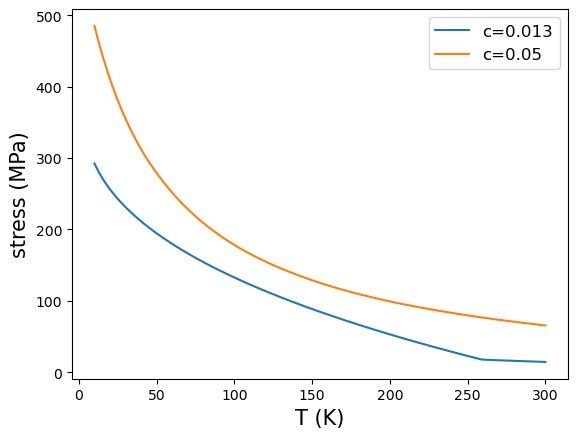

In [117]:
for c in c_range:
    df = df_stress_T[df_stress_T['c']==c]
    plt.plot(df['T'], df['stress'], label=f'c={c}')
    plt.xlabel('T (K)', fontsize=15)
    plt.ylabel('stress (MPa)', fontsize=15)
    plt.legend(fontsize=12)

### Here you can plot dislocation configurations 

/tmp/ipykernel_214482/331969248.py:2: RuntimeWarning: divide by zero encountered in divide
  return 0.5*(np.tanh((z+zeta)/alpha)-np.tanh((z-zeta)/alpha))


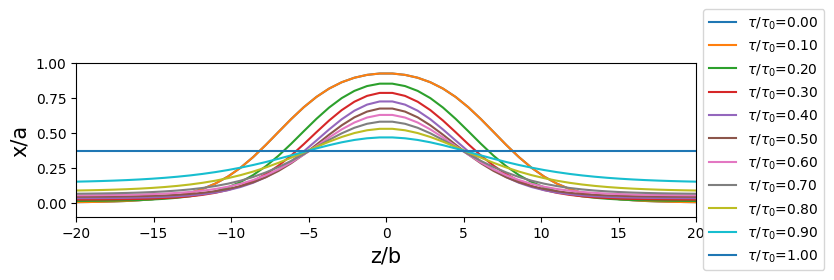

In [37]:
def g(z, tau, alpha, zeta):
    return 0.5*(np.tanh((z+zeta)/alpha)-np.tanh((z-zeta)/alpha))

alpha_data = {0: 4.347, 0.1: 4.347, 0.2: 4.381, 0.3: 4.444, 0.4: 4.571, 0.5: 4.792, 0.6: 5.184, 0.7: 5.755, 0.8: 6.725, 0.9: 7.886, 1: 0}
zeta_data = {0: 6.987, 0.1: 6.987, 0.2: 5.367, 0.3: 4.487, 0.4: 3.918, 0.5: 3.584, 0.6: 3.419, 0.7: 3.311, 0.8: 3.241, 0.9: 2.666, 1: 0}
geq_data = {0: 0, 0.1: 0, 0.2: 0.01, 0.3: 0.02, 0.4: 0.03, 0.5: 0.04, 0.6: 0.05, 0.7: 0.06, 0.8: 0.08, 0.9: 0.14, 1: 0.365}

# Convert to numpy arrays
x_alpha = np.array(list(alpha_data.keys()))
y_alpha = np.array(list(alpha_data.values()))

x_zeta = np.array(list(zeta_data.keys()))
y_zeta = np.array(list(zeta_data.values()))

x_geq = np.array(list(geq_data.keys()))
y_geq = np.array(list(geq_data.values()))

# Create interpolation functions
alpha_interp = interp1d(x_alpha, y_alpha, kind='cubic')  # Cubic interpolation
zeta_interp = interp1d(x_zeta, y_zeta, kind='cubic')
geq_interp = interp1d(x_geq, y_geq, kind='cubic')

z = np.linspace(-20, 20, 50)
tau_list = np.linspace(0, 1, 11)

fig = plt.figure(figsize=(8, 2))
for tau in tau_list:
    alpha, zeta, geq = alpha_interp(tau), zeta_interp(tau), geq_interp(tau)
    plt.plot(z, g(z, tau, alpha, zeta)+geq, label=r'$\tau/\tau_0$'+f'={tau:.2f}')
    plt.xlim(-20, 20)
    plt.ylim(-0.1, 1)
    plt.xlabel("z/b" , fontsize=15)
    plt.ylabel("x/a" , fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Here you can compute __G__

G(tau) = [[0.         3.09950246]
 [0.1        3.09950246]
 [0.2        2.54891308]
 [0.3        2.20077717]
 [0.4        1.94531654]
 [0.5        1.76853206]
 [0.6        1.6427428 ]
 [0.7        1.52540969]
 [0.8        1.39165779]
 [0.9        1.06494434]
 [1.                nan]]


/tmp/ipykernel_214482/331969248.py:2: RuntimeWarning: divide by zero encountered in divide
  return 0.5*(np.tanh((z+zeta)/alpha)-np.tanh((z-zeta)/alpha))
/tmp/ipykernel_214482/331969248.py:2: RuntimeWarning: invalid value encountered in divide
  return 0.5*(np.tanh((z+zeta)/alpha)-np.tanh((z-zeta)/alpha))


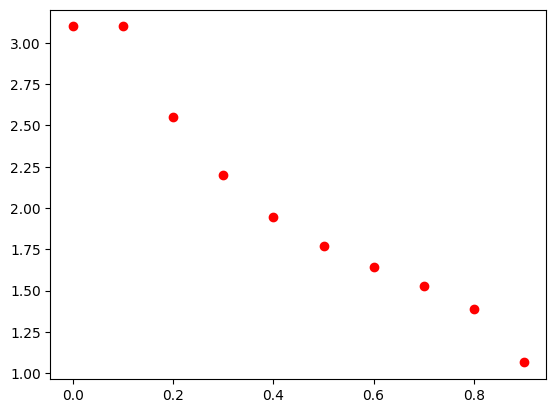

In [43]:
# Parameters
N_s = 10   # NUmber of atomic sites per l_dk/2
tau_range = np.linspace(0, 1, 11)  # Some value for tau

G_all = []
for tau in tau_range:
    alpha, zeta = alpha_interp(tau), zeta_interp(tau)
    G = np.sqrt(np.sum([g(z, tau, alpha, zeta)**2 for z in range(-N_s, N_s+1)]))
    G_all.append([tau, G])

print(f"G(tau) = {np.array(G_all)}")
plt.plot(np.array(G_all)[:, 0], np.array(G_all)[:, 1], 'ro')